# Objetivo

Criar um modelo de machine learning para fazer a previsão da classe churn de clientes com base em variáveis que não estáo diretamente associadas a classificação de negócio para encontrar padrãos de relação entre as variáveis e a classe churn.

In [2]:
# Manipulação de dados
import pandas as pd
import numpy as np
import redshift_connector

# Converter dados para date
from datetime import datetime

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, log_loss



from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# Vizualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Balanceamento das classes
from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import NearMiss
#import imblearn

In [3]:
# Parando as mensagens de warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Sumario

1 - Carregando o Dataset
2 - SQL utilizada para retirar os dados do BD IBM
3 - Convertendo os tipos dos dados
4 - Análise exploratória
5 - Correlação dos Dados
6 - Transformações nos dados e balanceamento de classes
7 - Testando vários modelos de classificação
8 - Procedimentos para entregar novos dados


## 1 - Carregando o Dataset

In [5]:
# Carregando o arquivo CSV dos dados que foram exportados do redshift

dataset = pd.read_csv("d_clients_mv4.csv")
dataset_BTYD = pd.read_csv("BTYD_probs.csv")

In [4]:
# Passando o arquivo CSV para Dataframe 

df = pd.DataFrame(dataset)

In [5]:
df.shape

(9103, 17)

In [6]:
df['risco_credito'].value_counts()

Risco Iminente        8509
Risco Baixo            212
Risco Médio            182
Risco Muito Baixo       75
Risco Considerável      53
Risco Relevante         39
Risco Mínimo            33
Name: risco_credito, dtype: int64

In [7]:
df['churn_class'].value_counts()

Em churn            5610
Ativo recorrente    3493
Name: churn_class, dtype: int64

In [8]:
# Verificando os tipos dos dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9103 entries, 0 to 9102
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ano_mes_dt_cad_rep  9103 non-null   object 
 1   cd_cliente          9103 non-null   int64  
 2   saldo_credev        9103 non-null   float64
 3   saldo_adiantamento  9103 non-null   float64
 4   score_empresas      9103 non-null   float64
 5   negativacoes        9103 non-null   float64
 6   pedidos             9103 non-null   int64  
 7   recencia            9103 non-null   int64  
 8   ds_tp_pessoa        9103 non-null   object 
 9   volume_compra       9103 non-null   object 
 10  risco_credito       9103 non-null   object 
 11  churn_class         9103 non-null   object 
 12  churn_class_number  9103 non-null   int64  
 13  soma_qt_cancelada   9103 non-null   float64
 14  soma_qt_pendente    9103 non-null   float64
 15  soma_vlr_cancelado  9103 non-null   float64
 16  soma_v

In [9]:
df.shape

(9103, 17)

## 3 - Convertendo os tipos dos dados

In [10]:
# Tipo object -  Variáveis convertidas para objects
cols_objects = ['cd_cliente','ds_tp_pessoa','risco_credito'
               ,'churn_class']
df[cols_objects] = df[cols_objects].astype(object)

# Tipo Inteiro -  Convertendo as variáveis do tipo inteiro
cols_ints = ['pedidos','recencia','churn_class_number','soma_qt_cancelada','soma_qt_pendente']
df[cols_ints] = df[cols_ints].astype(int)

# Tipo float -  Convertendo as variáveis do tipo float
cols_float = ['saldo_credev','saldo_adiantamento','score_empresas','negativacoes','soma_vlr_cancelado','soma_vlr_pendente']
df[cols_float] = df[cols_float].astype(float)

# Tipo Date -  Convertendo variáveis datetime - não vamos usar dados temporais neste modelo
df['ano_mes_dt_cad_rep'] = df['ano_mes_dt_cad_rep'] = pd.to_datetime(df['ano_mes_dt_cad_rep'], format='%Y-%m')

In [11]:
# Criando uma lista das variáveis numéricas para posterior análise

cols_numerics = ['pedidos','recencia','churn_class_number','soma_qt_cancelada','soma_qt_pendente',
                'saldo_credev','saldo_adiantamento','score_empresas','negativacoes','soma_vlr_cancelado','soma_vlr_pendente']

In [12]:
# Verificando novamente os tipos dos dados
# Agora todos as colunas estão com os tipos de dados corretos

df.dtypes

ano_mes_dt_cad_rep    datetime64[ns]
cd_cliente                    object
saldo_credev                 float64
saldo_adiantamento           float64
score_empresas               float64
negativacoes                 float64
pedidos                        int32
recencia                       int32
ds_tp_pessoa                  object
volume_compra                 object
risco_credito                 object
churn_class                   object
churn_class_number             int32
soma_qt_cancelada              int32
soma_qt_pendente               int32
soma_vlr_cancelado           float64
soma_vlr_pendente            float64
dtype: object

In [13]:
# Categorização dummy
dummies = ['risco_credito', 'volume_compra', 'ds_tp_pessoa']


num_df = pd.get_dummies(df[dummies])
num_df

,risco_credito_Risco Baixo,risco_credito_Risco Considerável,risco_credito_Risco Iminente,risco_credito_Risco Muito Baixo,risco_credito_Risco Médio,risco_credito_Risco Mínimo,risco_credito_Risco Relevante,volume_compra_ACIMA DE 90k,volume_compra_ATÉ 10k,volume_compra_DE 10k A 30k,volume_compra_DE 30k A 60k,ds_tp_pessoa_Fisica,ds_tp_pessoa_Juridica
0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,1,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,0,1,0,0,0,0,1
4,0,0,0,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,0,0,1,0,0,0,0,0,1,0,0,1,0
9099,0,0,1,0,0,0,0,0,1,0,0,1,0
9100,0,0,1,0,0,0,0,0,0,1,0,0,1
9101,0,0,1,0,0,0,0,0,1,0,0,1,0


In [14]:
df = pd.concat([df,num_df],axis=1)
df

,ano_mes_dt_cad_rep,cd_cliente,saldo_credev,saldo_adiantamento,score_empresas,negativacoes,pedidos,recencia,ds_tp_pessoa,volume_compra,...,risco_credito_Risco Muito Baixo,risco_credito_Risco Médio,risco_credito_Risco Mínimo,risco_credito_Risco Relevante,volume_compra_ACIMA DE 90k,volume_compra_ATÉ 10k,volume_compra_DE 10k A 30k,volume_compra_DE 30k A 60k,ds_tp_pessoa_Fisica,ds_tp_pessoa_Juridica
0,2016-06-01,4194,0.00,0.00,1.0,88752.62,29,102,Juridica,ACIMA DE 90k,...,0,0,0,0,1,0,0,0,0,1
1,2018-06-01,4512,129.99,129.99,622.0,0.00,15,57,Juridica,ACIMA DE 90k,...,0,0,0,0,1,0,0,0,0,1
2,2018-06-01,6307,2.73,2.73,0.0,0.00,4,110,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0
3,2018-06-01,10755,219.80,219.80,1.0,13508.78,23,16,Juridica,ACIMA DE 90k,...,0,0,0,0,1,0,0,0,0,1
4,2018-06-01,11778,0.00,0.00,390.0,0.00,40,62,Juridica,ACIMA DE 90k,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,2021-11-01,66897,0.00,0.00,0.0,0.00,2,1,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0
9099,2021-11-01,66919,0.00,0.00,0.0,0.00,2,2,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0
9100,2021-11-01,66953,0.00,0.00,0.0,0.00,2,1,Juridica,DE 10k A 30k,...,0,0,0,0,0,0,1,0,0,1
9101,2021-11-01,66976,0.00,401.94,0.0,0.00,2,1,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0


## 4 - Análise exploratória

In [15]:
# Verificando a proporção de classes churn
# Vai ser necessário equilivrar as classes para treinar o modelo
# A variável está codificada 0 para ativo recorrente 1 para em churn

df['churn_class'].value_counts()

Em churn            5610
Ativo recorrente    3493
Name: churn_class, dtype: int64

In [16]:
# Verificando o formato do dataset

df.shape

(9103, 30)

In [17]:
df

,ano_mes_dt_cad_rep,cd_cliente,saldo_credev,saldo_adiantamento,score_empresas,negativacoes,pedidos,recencia,ds_tp_pessoa,volume_compra,...,risco_credito_Risco Muito Baixo,risco_credito_Risco Médio,risco_credito_Risco Mínimo,risco_credito_Risco Relevante,volume_compra_ACIMA DE 90k,volume_compra_ATÉ 10k,volume_compra_DE 10k A 30k,volume_compra_DE 30k A 60k,ds_tp_pessoa_Fisica,ds_tp_pessoa_Juridica
0,2016-06-01,4194,0.00,0.00,1.0,88752.62,29,102,Juridica,ACIMA DE 90k,...,0,0,0,0,1,0,0,0,0,1
1,2018-06-01,4512,129.99,129.99,622.0,0.00,15,57,Juridica,ACIMA DE 90k,...,0,0,0,0,1,0,0,0,0,1
2,2018-06-01,6307,2.73,2.73,0.0,0.00,4,110,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0
3,2018-06-01,10755,219.80,219.80,1.0,13508.78,23,16,Juridica,ACIMA DE 90k,...,0,0,0,0,1,0,0,0,0,1
4,2018-06-01,11778,0.00,0.00,390.0,0.00,40,62,Juridica,ACIMA DE 90k,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,2021-11-01,66897,0.00,0.00,0.0,0.00,2,1,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0
9099,2021-11-01,66919,0.00,0.00,0.0,0.00,2,2,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0
9100,2021-11-01,66953,0.00,0.00,0.0,0.00,2,1,Juridica,DE 10k A 30k,...,0,0,0,0,0,0,1,0,0,1
9101,2021-11-01,66976,0.00,401.94,0.0,0.00,2,1,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0


## 5 - Correlação dos Dados

Analisamos a correlação entre as variáveis numéricas e entre as variáveis numéricas e a variável alvo (o que estamos querendo analisar).

In [18]:
# Vai ser necessário filtrar as colunas de valor pois elas apresentam dados 
# colineares(colunas se tratando do mesmo tipo de dado)

df.corr("spearman")

,saldo_credev,saldo_adiantamento,score_empresas,negativacoes,pedidos,recencia,churn_class_number,soma_qt_cancelada,soma_qt_pendente,soma_vlr_cancelado,...,risco_credito_Risco Muito Baixo,risco_credito_Risco Médio,risco_credito_Risco Mínimo,risco_credito_Risco Relevante,volume_compra_ACIMA DE 90k,volume_compra_ATÉ 10k,volume_compra_DE 10k A 30k,volume_compra_DE 30k A 60k,ds_tp_pessoa_Fisica,ds_tp_pessoa_Juridica
saldo_credev,1.000000,0.803809,0.047145,0.003316,0.234275,-0.052399,-0.070726,0.111797,0.024057,0.111405,...,0.035802,0.025744,0.010491,0.004010,0.065645,-0.045706,0.005134,-0.011986,-0.010307,0.010307
saldo_adiantamento,0.803809,1.000000,0.063920,0.021995,0.306561,-0.140966,-0.167131,0.220586,0.079575,0.220204,...,0.030463,0.041275,0.000716,0.012249,0.098809,-0.099718,0.038018,0.011336,-0.071951,0.071951
score_empresas,0.047145,0.063920,1.000000,0.412733,0.417642,-0.163729,-0.214203,0.717670,0.697651,0.716745,...,0.326751,0.473139,0.218846,0.208706,0.718963,-0.817906,0.293258,0.270616,-0.811212,0.811212
negativacoes,0.003316,0.021995,0.412733,1.000000,0.196285,-0.082021,-0.101589,0.334097,0.304741,0.333711,...,-0.002519,0.145994,-0.007860,0.082934,0.417849,-0.359342,0.055355,0.049011,-0.354229,0.354229
pedidos,0.234275,0.306561,0.417642,0.196285,1.000000,-0.488425,-0.580681,0.502002,0.392724,0.500656,...,0.125556,0.197327,0.082304,0.093102,0.400102,-0.447779,0.157400,0.141625,-0.393339,0.393339
recencia,-0.052399,-0.140966,-0.163729,-0.082021,-0.488425,1.000000,0.842370,-0.166583,-0.295910,-0.165972,...,-0.063395,-0.066420,-0.032772,-0.038918,-0.205215,0.216701,-0.066534,-0.062352,0.183965,-0.183965
churn_class_number,-0.070726,-0.167131,-0.214203,-0.101589,-0.580681,0.842370,1.000000,-0.237452,-0.334749,-0.237295,...,-0.073025,-0.093866,-0.042614,-0.055460,-0.229983,0.271807,-0.108440,-0.089886,0.243088,-0.243088
soma_qt_cancelada,0.111797,0.220586,0.717670,0.334097,0.502002,-0.166583,-0.237452,1.000000,0.562968,0.999696,...,0.209483,0.339127,0.146889,0.153939,0.603733,-0.686953,0.259155,0.210006,-0.680458,0.680458
soma_qt_pendente,0.024057,0.079575,0.697651,0.304741,0.392724,-0.295910,-0.334749,0.562968,1.000000,0.562030,...,0.232811,0.317051,0.135851,0.153772,0.656349,-0.813349,0.332416,0.311231,-0.821830,0.821830
soma_vlr_cancelado,0.111405,0.220204,0.716745,0.333711,0.500656,-0.165972,-0.237295,0.999696,0.562030,1.000000,...,0.209220,0.338546,0.146009,0.154076,0.603702,-0.685768,0.257506,0.209596,-0.679045,0.679045


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9103 entries, 0 to 9102
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ano_mes_dt_cad_rep                9103 non-null   datetime64[ns]
 1   cd_cliente                        9103 non-null   object        
 2   saldo_credev                      9103 non-null   float64       
 3   saldo_adiantamento                9103 non-null   float64       
 4   score_empresas                    9103 non-null   float64       
 5   negativacoes                      9103 non-null   float64       
 6   pedidos                           9103 non-null   int32         
 7   recencia                          9103 non-null   int32         
 8   ds_tp_pessoa                      9103 non-null   object        
 9   volume_compra                     9103 non-null   object        
 10  risco_credito                     9103 non-null 

In [20]:
df = pd.concat([df,dataset_BTYD],axis=1)
df

,ano_mes_dt_cad_rep,cd_cliente,saldo_credev,saldo_adiantamento,score_empresas,negativacoes,pedidos,recencia,ds_tp_pessoa,volume_compra,...,ds_tp_pessoa_Juridica,cd_cliente,frequency,recency,T,monetary_value,pred_num_trans_30,pred_trans_avg_value,CLV,prob_alive
0,2016-06-01,4194,0.00,0.00,1.0,88752.62,29.0,102.0,Juridica,ACIMA DE 90k,...,1.0,17,22.0,323.0,324.0,5848.337727,1.89,5855.60,122261.24,0.997032
1,2018-06-01,4512,129.99,129.99,622.0,0.00,15.0,57.0,Juridica,ACIMA DE 90k,...,1.0,20,22.0,323.0,324.0,4471.842273,1.89,4477.54,93488.24,0.997032
2,2018-06-01,6307,2.73,2.73,0.0,0.00,4.0,110.0,Fisica,ATÉ 10k,...,0.0,21,18.0,296.0,304.0,3631.973889,1.64,3637.77,65837.01,0.994641
3,2018-06-01,10755,219.80,219.80,1.0,13508.78,23.0,16.0,Juridica,ACIMA DE 90k,...,1.0,42,23.0,310.0,334.0,20726.692174,1.91,20749.80,435926.03,0.986928
4,2018-06-01,11778,0.00,0.00,390.0,0.00,40.0,62.0,Juridica,ACIMA DE 90k,...,1.0,50,5.0,66.0,323.0,6582.120000,0.03,6617.88,1986.45,0.060559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16424,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,69164,0.0,0.0,0.0,0.000000,0.27,-545.70,NaN,1.000000
16425,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,69165,0.0,0.0,0.0,0.000000,0.27,-545.70,NaN,1.000000
16426,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,110000001,115.0,326.0,327.0,248565.753391,9.75,248619.83,26722490.60,0.999282
16427,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,110000004,3.0,187.0,335.0,41020.243333,0.23,41368.96,106644.72,0.868162


In [21]:
# Analisando as correlações com a TX churn existem algumas variáveis com baixa correlação
# Vou remover essas variáveis para deixar o modelo mais generalista
# Vou aproveitar e remover as variáveis que não vão entrar no modelo
# Pois o modelo pode ficar enviezado por essas variáveis fazerem parte da regra de negócio que classifica o churn
vars_baixa_corr = ['cd_cliente','ds_tp_pessoa','volume_compra','risco_credito','churn_class','recencia','ano_mes_dt_cad_rep','saldo_credev'
                  ,'frequency','recency','T','monetary_value','pred_num_trans_30','pred_trans_avg_value','CLV']
df_2 = df.drop(columns=vars_baixa_corr)

In [22]:
# Verificando as colunas do novo dataset com as variáveis com uma correlação relativamente aceitavel
df_2 = df.dropna()
df_2

,ano_mes_dt_cad_rep,cd_cliente,saldo_credev,saldo_adiantamento,score_empresas,negativacoes,pedidos,recencia,ds_tp_pessoa,volume_compra,...,ds_tp_pessoa_Juridica,cd_cliente,frequency,recency,T,monetary_value,pred_num_trans_30,pred_trans_avg_value,CLV,prob_alive
0,2016-06-01,4194,0.00,0.00,1.0,88752.62,29.0,102.0,Juridica,ACIMA DE 90k,...,1.0,17,22.0,323.0,324.0,5848.337727,1.89,5855.60,122261.24,0.997032
1,2018-06-01,4512,129.99,129.99,622.0,0.00,15.0,57.0,Juridica,ACIMA DE 90k,...,1.0,20,22.0,323.0,324.0,4471.842273,1.89,4477.54,93488.24,0.997032
2,2018-06-01,6307,2.73,2.73,0.0,0.00,4.0,110.0,Fisica,ATÉ 10k,...,0.0,21,18.0,296.0,304.0,3631.973889,1.64,3637.77,65837.01,0.994641
3,2018-06-01,10755,219.80,219.80,1.0,13508.78,23.0,16.0,Juridica,ACIMA DE 90k,...,1.0,42,23.0,310.0,334.0,20726.692174,1.91,20749.80,435926.03,0.986928
4,2018-06-01,11778,0.00,0.00,390.0,0.00,40.0,62.0,Juridica,ACIMA DE 90k,...,1.0,50,5.0,66.0,323.0,6582.120000,0.03,6617.88,1986.45,0.060559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,2021-11-01,66897,0.00,0.00,0.0,0.00,2.0,1.0,Fisica,ATÉ 10k,...,0.0,60562,3.0,78.0,130.0,199.146667,0.56,205.40,1249.98,0.907799
9099,2021-11-01,66919,0.00,0.00,0.0,0.00,2.0,2.0,Fisica,ATÉ 10k,...,0.0,60563,0.0,0.0,130.0,0.000000,0.05,-545.70,-269.02,1.000000
9100,2021-11-01,66953,0.00,0.00,0.0,0.00,2.0,1.0,Juridica,DE 10k A 30k,...,1.0,60564,1.0,33.0,130.0,195.730000,0.11,214.71,259.00,0.469891
9101,2021-11-01,66976,0.00,401.94,0.0,0.00,2.0,1.0,Fisica,ATÉ 10k,...,0.0,60565,1.0,26.0,130.0,127.490000,0.10,144.72,160.00,0.430664


In [23]:
# Passando a variável target para o tipo fator novamente

df_2['churn_class_number'] = df_2['churn_class_number'].astype(object)
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8538 entries, 0 to 9102
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ano_mes_dt_cad_rep                8538 non-null   datetime64[ns]
 1   cd_cliente                        8538 non-null   object        
 2   saldo_credev                      8538 non-null   float64       
 3   saldo_adiantamento                8538 non-null   float64       
 4   score_empresas                    8538 non-null   float64       
 5   negativacoes                      8538 non-null   float64       
 6   pedidos                           8538 non-null   float64       
 7   recencia                          8538 non-null   float64       
 8   ds_tp_pessoa                      8538 non-null   object        
 9   volume_compra                     8538 non-null   object        
 10  risco_credito                     8538 non-null 

In [24]:
# Verificando a distribuição das classes 0 e 1
df_2['churn_class_number'].value_counts()

1.0    5103
0.0    3435
Name: churn_class_number, dtype: int64

## 6 - Transformações nos dados e balanceamento de classes

In [25]:
# Normalização das variáveis numéricas, vou colocar elas todas na mesma escala
# Antes disso vou criar meu dataset de preditores e dataset de target   

preditores = ['saldo_adiantamento','score_empresas','negativacoes','pedidos','risco_credito_Risco Baixo',
             'risco_credito_Risco Considerável','risco_credito_Risco Iminente','risco_credito_Risco Muito Baixo',
             'risco_credito_Risco Médio','risco_credito_Risco Mínimo','risco_credito_Risco Relevante','volume_compra_ACIMA DE 90k',
             'volume_compra_ATÉ 10k','volume_compra_DE 10k A 30k','volume_compra_DE 30k A 60k'
              ,'ds_tp_pessoa_Fisica','ds_tp_pessoa_Juridica','soma_qt_cancelada','soma_qt_pendente','prob_alive']
target = ['churn_class_number']

X_ = df_2[preditores]
Y_ = df_2[target].astype(int)

In [26]:
# Balanceamento de classes com SMOTE
smt = SMOTE()

X, Y = smt.fit_resample(X_, Y_)
Y = Y.astype(int)
# Nova distribuição das classes balanceadas
Y.value_counts()

churn_class_number
0                     5103
1                     5103
dtype: int64

In [27]:
# Normalização dos dados

#min_max_scaler = preprocessing.MinMaxScaler()
#X = min_max_scaler.fit_transform(X)
#X_ = min_max_scaler.fit_transform(X_)

In [28]:
# Agora vou fazer a divisão dos dados de treino e teste com proporção de 30% para teste
# Divisão em dados de treino e de teste
# Não irei balancear as classes para o modelo RF pois apresenta um desempenho mt bom sem o balanceamento

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3)
x_train_, x_valid_, y_train_, y_valid_ = train_test_split(X_, Y_, test_size=0.3)

In [29]:
# Imprimindo o número de exemplos (observações) em cada dataset
print("Exemplos de Treino: {}".format(len(x_train)))
print("Exemplos de Validação: {}".format(len(y_valid)))
print("Exemplos de Teste: {}".format(len(y_train)))

Exemplos de Treino: 7144
Exemplos de Validação: 3062
Exemplos de Teste: 7144


## 7 - Testando vários modelos de classificação

In [30]:
# Treinando vários modelos para teste

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# modelLR = LogisticRegression(penalty='none')
# modelLR.fit(x_train, y_train)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
modelRF = RandomForestClassifier(max_depth=8, max_features=10, min_samples_leaf=4,
                       min_samples_split=10)
modelRF.fit(x_train_, y_train_)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
modelGB = GradientBoostingClassifier(loss='exponential', n_estimators=150)
modelGB.fit(x_train, y_train)

# https://scikit-learn.org/stable/modules/svm.html
# modelSVM = svm.SVC()
# modelSVM.fit(x_train, y_train)

# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# modelKN = KNeighborsClassifier(n_neighbors=3)
# modelKN.fit(x_train, y_train)   
    
# https://scikit-learn.org/stable/modules/naive_bayes.html
# modelNB = GaussianNB()
# modelNB = modelNB.fit(x_train, y_train)

GradientBoostingClassifier(loss='exponential', n_estimators=150)

In [31]:
# Os modelos RF e GB demonstraram melhor desemprenho dos demais, 
# por isso irei aplicar o RSearch no GB e RF para otimizar seus parametros
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

# RF
# Definição dos parâmetros
#param_dist = {"max_depth": [1, 3, 7, 8, 12, None],
#              "max_features": [8, 9, 10, 11, 16, 22],
#              "min_samples_split": [8, 10, 11, 14, 16, 19],
#              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
#              "bootstrap": [True, False]}

# Para o classificador criado com ExtraTrees, testamos diferentes combinações de parâmetros
# rsearch = RandomizedSearchCV(modelRF, param_distributions = param_dist, n_iter = 35, return_train_score = True)  

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
# rsearch.fit(x_train_, y_train_)

# Resultados 
# rsearch.cv_results_

# Imprimindo o melhor estimador
# modelRF = rsearch.best_estimator_
# print (modelRF)

# Aplicando o melhor estimador para realizar as previsões
# y_pred = modelRF.predict(x_valid_)

# Confusion Matrix
# confusionMatrix = confusion_matrix(y_valid_, y_pred)
# print(confusionMatrix)

# Acurácia
# accuracy = accuracy_score(y_valid_, y_pred)
# print(accuracy)

In [32]:
# Os modelos RF e GB demonstraram melhor desemprenho dos demais, 
# por isso irei aplicar o RSearch no GB e RF para otimizar seus parametros
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

# GB
# Definição dos parâmetros
# param_dist = {"loss": ['deviance', 'exponential'],
#               "learning_rate": [0.1, 0.03, 0.5, 0.7],
#               "n_estimators": [50, 100, 150, 200],
#               "subsample": [1.0,3.0],
#               "criterion": ['friedman_mse', 'mse']}

# Para o classificador criado com ExtraTrees, testamos diferentes combinações de parâmetros
# rsearch = RandomizedSearchCV(modelGB, param_distributions = param_dist, n_iter = 35, return_train_score = True)  

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
# rsearch.fit(x_train_, y_train_)

# Resultados 
# rsearch.cv_results_

# Imprimindo o melhor estimador
# modelGB = rsearch.best_estimator_
# print (modelGB)

# Aplicando o melhor estimador para realizar as previsões
# y_pred = modelGB.predict(x_valid_)

# Confusion Matrix
# confusionMatrix = confusion_matrix(y_valid_, y_pred)
# print(confusionMatrix)

# Acurácia
# accuracy = accuracy_score(y_valid_, y_pred)
# print(accuracy)

In [33]:
# predictLR = modelLR.predict(x_valid)
# print('Logistic Regression: \n', classification_report(predictLR, y_valid))
# print('Logistic Regression Accuracy: ', accuracy_score(predictLR, y_valid))

predictRF = modelRF.predict(x_valid_)
print('Random Forest Classifier : \n', classification_report(predictRF, y_valid_))
print('Random Forest Classifier Accuracy: ', accuracy_score(predictRF, y_valid_))

predictGB = modelGB.predict(x_valid)
print('Gradient Boost Classifier : \n', classification_report(predictGB, y_valid))
print('Gradient Boost Classifier Accuracy: ', accuracy_score(predictGB, y_valid))

# predictSVM = modelSVM.predict(x_valid)
# print('SVM : \n', classification_report(predictSVM, y_valid))
# print('SVM Accuracy: ', accuracy_score(predictSVM, y_valid))

# predictKN = modelKN.predict(x_valid)
# print('KN : \n', classification_report(predictKN, y_valid))
# print('KN Accuracy: ', accuracy_score(predictKN, y_valid))

# predictNB = modelNB.predict(x_valid)
# print('NB : \n', classification_report(predictNB, y_valid))
# print('NB Accuracy: ', accuracy_score(predictNB, y_valid))

Random Forest Classifier : 
               precision    recall  f1-score   support

           0       0.82      0.72      0.77      1212
           1       0.78      0.86      0.82      1350

    accuracy                           0.79      2562
   macro avg       0.80      0.79      0.79      2562
weighted avg       0.80      0.79      0.79      2562

Random Forest Classifier Accuracy:  0.7946916471506635
Gradient Boost Classifier : 
               precision    recall  f1-score   support

           0       0.96      0.73      0.83      2010
           1       0.65      0.95      0.77      1052

    accuracy                           0.81      3062
   macro avg       0.81      0.84      0.80      3062
weighted avg       0.86      0.81      0.81      3062

Gradient Boost Classifier Accuracy:  0.8056825604180274


In [34]:
# Confusion Matrix do Modelo Final
# print ("Confusion matrix")
# print('LR',confusion_matrix(predictLR, y_valid))
print('RF',confusion_matrix(predictRF, y_valid_))
print('GB',confusion_matrix(predictGB, y_valid))
# print('SVM',confusion_matrix(predictSVM, y_valid))
# print('KN',confusion_matrix(predictKN, y_valid))
# print('NB',confusion_matrix(predictNB, y_valid))

RF [[ 876  336]
 [ 190 1160]]
GB [[1471  539]
 [  56  996]]


## 8 - Procedimentos para entregar novos dados

In [35]:
# Carregando o arquivo CSV com novos dados para previsão

novos_dados = pd.read_csv("novosdados_mv4.csv")

In [36]:
novos_dados.shape

(9103, 17)

In [37]:
# Passando o arquivo CSV para Dataframe 
df_novos_dados = pd.DataFrame(novos_dados)

In [38]:
# Tipo object -  Variáveis convertidas para objects
cols_objects = ['cd_cliente','ds_tp_pessoa','risco_credito'
               ,'churn_class']
df_novos_dados[cols_objects] = df_novos_dados[cols_objects].astype(object)

# Tipo Inteiro -  Convertendo as variáveis do tipo inteiro
cols_ints = ['pedidos','recencia','churn_class_number']
df_novos_dados[cols_ints] = df_novos_dados[cols_ints].astype(int)

# Tipo float -  Convertendo as variáveis do tipo float
cols_float = ['saldo_credev','saldo_adiantamento','score_empresas','negativacoes']
df_novos_dados[cols_float] = df_novos_dados[cols_float].astype(float)

# Tipo Date -  Convertendo variáveis datetime - não vamos usar dados temporais neste modelo
df_novos_dados['ano_mes_dt_cad_rep'] = df_novos_dados['ano_mes_dt_cad_rep'] = pd.to_datetime(df_novos_dados['ano_mes_dt_cad_rep'], format='%Y-%m')

In [39]:
# Categorização dummy
dummies = ['risco_credito', 'volume_compra', 'ds_tp_pessoa']


num_df_new = pd.get_dummies(df_novos_dados[dummies])
num_df_new

,risco_credito_Risco Baixo,risco_credito_Risco Considerável,risco_credito_Risco Iminente,risco_credito_Risco Muito Baixo,risco_credito_Risco Médio,risco_credito_Risco Mínimo,risco_credito_Risco Relevante,volume_compra_ACIMA DE 90k,volume_compra_ATÉ 10k,volume_compra_DE 10k A 30k,volume_compra_DE 30k A 60k,ds_tp_pessoa_Fisica,ds_tp_pessoa_Juridica
0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,1,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,0,1,0,0,0,0,1
4,0,0,0,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,0,0,1,0,0,0,0,0,1,0,0,1,0
9099,0,0,1,0,0,0,0,0,1,0,0,1,0
9100,0,0,1,0,0,0,0,0,0,1,0,0,1
9101,0,0,1,0,0,0,0,0,1,0,0,1,0


In [40]:
df_3 = pd.concat([df_novos_dados,num_df_new],axis=1)
df_3

,ano_mes_dt_cad_rep,cd_cliente,saldo_credev,saldo_adiantamento,score_empresas,negativacoes,pedidos,recencia,ds_tp_pessoa,volume_compra,...,risco_credito_Risco Muito Baixo,risco_credito_Risco Médio,risco_credito_Risco Mínimo,risco_credito_Risco Relevante,volume_compra_ACIMA DE 90k,volume_compra_ATÉ 10k,volume_compra_DE 10k A 30k,volume_compra_DE 30k A 60k,ds_tp_pessoa_Fisica,ds_tp_pessoa_Juridica
0,2016-06-01,4194,0.00,0.00,1.0,88752.62,29,102,Juridica,ACIMA DE 90k,...,0,0,0,0,1,0,0,0,0,1
1,2018-06-01,4512,129.99,129.99,622.0,0.00,15,57,Juridica,ACIMA DE 90k,...,0,0,0,0,1,0,0,0,0,1
2,2018-06-01,6307,2.73,2.73,0.0,0.00,4,110,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0
3,2018-06-01,10755,219.80,219.80,1.0,13508.78,23,16,Juridica,ACIMA DE 90k,...,0,0,0,0,1,0,0,0,0,1
4,2018-06-01,11778,0.00,0.00,390.0,0.00,40,62,Juridica,ACIMA DE 90k,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,2021-11-01,66897,0.00,0.00,0.0,0.00,2,1,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0
9099,2021-11-01,66919,0.00,0.00,0.0,0.00,2,2,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0
9100,2021-11-01,66953,0.00,0.00,0.0,0.00,2,1,Juridica,DE 10k A 30k,...,0,0,0,0,0,0,1,0,0,1
9101,2021-11-01,66976,0.00,401.94,0.0,0.00,2,1,Fisica,ATÉ 10k,...,0,0,0,0,0,1,0,0,1,0


In [41]:
df_3 = pd.concat([df_3,dataset_BTYD],axis=1)
df

,ano_mes_dt_cad_rep,cd_cliente,saldo_credev,saldo_adiantamento,score_empresas,negativacoes,pedidos,recencia,ds_tp_pessoa,volume_compra,...,ds_tp_pessoa_Juridica,cd_cliente,frequency,recency,T,monetary_value,pred_num_trans_30,pred_trans_avg_value,CLV,prob_alive
0,2016-06-01,4194,0.00,0.00,1.0,88752.62,29.0,102.0,Juridica,ACIMA DE 90k,...,1.0,17,22.0,323.0,324.0,5848.337727,1.89,5855.60,122261.24,0.997032
1,2018-06-01,4512,129.99,129.99,622.0,0.00,15.0,57.0,Juridica,ACIMA DE 90k,...,1.0,20,22.0,323.0,324.0,4471.842273,1.89,4477.54,93488.24,0.997032
2,2018-06-01,6307,2.73,2.73,0.0,0.00,4.0,110.0,Fisica,ATÉ 10k,...,0.0,21,18.0,296.0,304.0,3631.973889,1.64,3637.77,65837.01,0.994641
3,2018-06-01,10755,219.80,219.80,1.0,13508.78,23.0,16.0,Juridica,ACIMA DE 90k,...,1.0,42,23.0,310.0,334.0,20726.692174,1.91,20749.80,435926.03,0.986928
4,2018-06-01,11778,0.00,0.00,390.0,0.00,40.0,62.0,Juridica,ACIMA DE 90k,...,1.0,50,5.0,66.0,323.0,6582.120000,0.03,6617.88,1986.45,0.060559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16424,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,69164,0.0,0.0,0.0,0.000000,0.27,-545.70,NaN,1.000000
16425,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,69165,0.0,0.0,0.0,0.000000,0.27,-545.70,NaN,1.000000
16426,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,110000001,115.0,326.0,327.0,248565.753391,9.75,248619.83,26722490.60,0.999282
16427,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,110000004,3.0,187.0,335.0,41020.243333,0.23,41368.96,106644.72,0.868162


In [42]:
# Dropando valores NA
df_3 = df.dropna()

In [43]:
df_3['churn_class'].value_counts()

Em churn            5103
Ativo recorrente    3435
Name: churn_class, dtype: int64

In [44]:
df_3

,ano_mes_dt_cad_rep,cd_cliente,saldo_credev,saldo_adiantamento,score_empresas,negativacoes,pedidos,recencia,ds_tp_pessoa,volume_compra,...,ds_tp_pessoa_Juridica,cd_cliente,frequency,recency,T,monetary_value,pred_num_trans_30,pred_trans_avg_value,CLV,prob_alive
0,2016-06-01,4194,0.00,0.00,1.0,88752.62,29.0,102.0,Juridica,ACIMA DE 90k,...,1.0,17,22.0,323.0,324.0,5848.337727,1.89,5855.60,122261.24,0.997032
1,2018-06-01,4512,129.99,129.99,622.0,0.00,15.0,57.0,Juridica,ACIMA DE 90k,...,1.0,20,22.0,323.0,324.0,4471.842273,1.89,4477.54,93488.24,0.997032
2,2018-06-01,6307,2.73,2.73,0.0,0.00,4.0,110.0,Fisica,ATÉ 10k,...,0.0,21,18.0,296.0,304.0,3631.973889,1.64,3637.77,65837.01,0.994641
3,2018-06-01,10755,219.80,219.80,1.0,13508.78,23.0,16.0,Juridica,ACIMA DE 90k,...,1.0,42,23.0,310.0,334.0,20726.692174,1.91,20749.80,435926.03,0.986928
4,2018-06-01,11778,0.00,0.00,390.0,0.00,40.0,62.0,Juridica,ACIMA DE 90k,...,1.0,50,5.0,66.0,323.0,6582.120000,0.03,6617.88,1986.45,0.060559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,2021-11-01,66897,0.00,0.00,0.0,0.00,2.0,1.0,Fisica,ATÉ 10k,...,0.0,60562,3.0,78.0,130.0,199.146667,0.56,205.40,1249.98,0.907799
9099,2021-11-01,66919,0.00,0.00,0.0,0.00,2.0,2.0,Fisica,ATÉ 10k,...,0.0,60563,0.0,0.0,130.0,0.000000,0.05,-545.70,-269.02,1.000000
9100,2021-11-01,66953,0.00,0.00,0.0,0.00,2.0,1.0,Juridica,DE 10k A 30k,...,1.0,60564,1.0,33.0,130.0,195.730000,0.11,214.71,259.00,0.469891
9101,2021-11-01,66976,0.00,401.94,0.0,0.00,2.0,1.0,Fisica,ATÉ 10k,...,0.0,60565,1.0,26.0,130.0,127.490000,0.10,144.72,160.00,0.430664


In [45]:
# Colocando os dados no mesmo padrão dos dados de treino


preditores_new = ['saldo_adiantamento','score_empresas','negativacoes','pedidos','risco_credito_Risco Baixo',
             'risco_credito_Risco Considerável','risco_credito_Risco Iminente','risco_credito_Risco Muito Baixo',
             'risco_credito_Risco Médio','risco_credito_Risco Mínimo','risco_credito_Risco Relevante','volume_compra_ACIMA DE 90k',
             'volume_compra_ATÉ 10k','volume_compra_DE 10k A 30k','volume_compra_DE 30k A 60k'
              ,'ds_tp_pessoa_Fisica','ds_tp_pessoa_Juridica','soma_qt_cancelada','soma_qt_pendente','prob_alive']
X_new_2 = df_3[preditores_new]

In [46]:
# Normalização dos dados
#min_max_scaler = preprocessing.MinMaxScaler()
#X_new = min_max_scaler.fit_transform(X_new)

In [47]:
# Fazendo previsão com novos dados
# predictLR_2 = modelLR.predict(X_new)
# predictLR_2_prob = modelLR.predict_proba(X_new)
# print('Logistic Regression: \n', classification_report(predictLR_2, df_2['churn_class_number']))
# print('Logistic Regression Accuracy: ', accuracy_score(predictLR_2, df_2['churn_class_number']))

predictRF_2 = modelRF.predict(X_new_2)
predictRF_2_prob = modelRF.predict_proba(X_new_2)
print('Random Forest Classifier : \n', classification_report(predictRF_2, df_3['churn_class_number']))
print('Random Forest Classifier Accuracy: ', accuracy_score(predictRF_2, df_3['churn_class_number']))

predictGB_2 = modelGB.predict(X_new_2)
predictGB_2_prob = modelGB.predict_proba(X_new_2)
print('Gradient Boost Classifier : \n', classification_report(predictGB_2, df_3['churn_class_number']))
print('Gradient Boost Classifier Accuracy: ', accuracy_score(predictGB_2, df_3['churn_class_number']))

# predictSVM_2 = modelSVM.predict(X_new)
# print('SVM Classifier : \n', classification_report(predictSVM_2, df_2['churn_class_number']))
# print('SVM Classifier Accuracy: ', accuracy_score(predictSVM_2, df_2['churn_class_number']))

# predictKN_2 = modelKN.predict(X_new)
# predictKN_2_prob = modelKN.predict_proba(X_new)
# print('KN Classifier : \n', classification_report(predictKN_2, df_2['churn_class_number']))
# print('KN Classifier Accuracy: ', accuracy_score(predictKN_2, df_2['churn_class_number']))

# predictNB_2 = modelNB.predict(X_new)
# predictNB_2_prob = modelNB.predict_proba(X_new)
# print('NB Classifier : \n', classification_report(predictNB_2, df_2['churn_class_number']))
# print('NB Classifier Accuracy: ', accuracy_score(predictNB_2, df_2['churn_class_number']))

Random Forest Classifier : 
               precision    recall  f1-score   support

           0       0.84      0.73      0.78      3949
           1       0.79      0.88      0.83      4589

    accuracy                           0.81      8538
   macro avg       0.82      0.81      0.81      8538
weighted avg       0.81      0.81      0.81      8538

Random Forest Classifier Accuracy:  0.8109627547434997
Gradient Boost Classifier : 
               precision    recall  f1-score   support

           0       0.97      0.67      0.79      4968
           1       0.68      0.97      0.80      3570

    accuracy                           0.79      8538
   macro avg       0.82      0.82      0.79      8538
weighted avg       0.85      0.79      0.79      8538

Gradient Boost Classifier Accuracy:  0.7939798547669243


In [48]:
# Criando as colunas de previsão de cada modelo no dataset
# df_2['predictLR_2'] = list(predictLR_2)
df_3['predictRF_2'] = list(predictRF_2)
df_3['predictGB_2'] = list(predictGB_2)
# df_2['predictSVM_2'] = list(predictSVM_2)
# df_2['predictKN_2'] = list(predictKN_2)
# df_2['predictNB_2'] = list(predictNB_2)

In [49]:
# Criando as colunas de previsão probabilistica de cada modelo no dataset
# df_2['predictLR_2_prob'] = list(predictLR_2_prob)
df_2['predictRF_2_prob'] = list(predictRF_2_prob)
df_2['predictGB_2_prob'] = list(predictGB_2_prob)
# df_2['predictKN_2_prob'] = list(predictKN_2_prob)
# df_2['predictNB_2_prob'] = list(predictNB_2_prob)

In [50]:
df_3

,ano_mes_dt_cad_rep,cd_cliente,saldo_credev,saldo_adiantamento,score_empresas,negativacoes,pedidos,recencia,ds_tp_pessoa,volume_compra,...,frequency,recency,T,monetary_value,pred_num_trans_30,pred_trans_avg_value,CLV,prob_alive,predictRF_2,predictGB_2
0,2016-06-01,4194,0.00,0.00,1.0,88752.62,29.0,102.0,Juridica,ACIMA DE 90k,...,22.0,323.0,324.0,5848.337727,1.89,5855.60,122261.24,0.997032,1,0
1,2018-06-01,4512,129.99,129.99,622.0,0.00,15.0,57.0,Juridica,ACIMA DE 90k,...,22.0,323.0,324.0,4471.842273,1.89,4477.54,93488.24,0.997032,0,0
2,2018-06-01,6307,2.73,2.73,0.0,0.00,4.0,110.0,Fisica,ATÉ 10k,...,18.0,296.0,304.0,3631.973889,1.64,3637.77,65837.01,0.994641,1,1
3,2018-06-01,10755,219.80,219.80,1.0,13508.78,23.0,16.0,Juridica,ACIMA DE 90k,...,23.0,310.0,334.0,20726.692174,1.91,20749.80,435926.03,0.986928,0,0
4,2018-06-01,11778,0.00,0.00,390.0,0.00,40.0,62.0,Juridica,ACIMA DE 90k,...,5.0,66.0,323.0,6582.120000,0.03,6617.88,1986.45,0.060559,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,2021-11-01,66897,0.00,0.00,0.0,0.00,2.0,1.0,Fisica,ATÉ 10k,...,3.0,78.0,130.0,199.146667,0.56,205.40,1249.98,0.907799,1,0
9099,2021-11-01,66919,0.00,0.00,0.0,0.00,2.0,2.0,Fisica,ATÉ 10k,...,0.0,0.0,130.0,0.000000,0.05,-545.70,-269.02,1.000000,0,0
9100,2021-11-01,66953,0.00,0.00,0.0,0.00,2.0,1.0,Juridica,DE 10k A 30k,...,1.0,33.0,130.0,195.730000,0.11,214.71,259.00,0.469891,0,0
9101,2021-11-01,66976,0.00,401.94,0.0,0.00,2.0,1.0,Fisica,ATÉ 10k,...,1.0,26.0,130.0,127.490000,0.10,144.72,160.00,0.430664,0,0


In [51]:
df_3.to_csv('predictions_new_mv4.csv', index=False, encoding='utf-8')

In [52]:
df_3

,ano_mes_dt_cad_rep,cd_cliente,saldo_credev,saldo_adiantamento,score_empresas,negativacoes,pedidos,recencia,ds_tp_pessoa,volume_compra,...,frequency,recency,T,monetary_value,pred_num_trans_30,pred_trans_avg_value,CLV,prob_alive,predictRF_2,predictGB_2
0,2016-06-01,4194,0.00,0.00,1.0,88752.62,29.0,102.0,Juridica,ACIMA DE 90k,...,22.0,323.0,324.0,5848.337727,1.89,5855.60,122261.24,0.997032,1,0
1,2018-06-01,4512,129.99,129.99,622.0,0.00,15.0,57.0,Juridica,ACIMA DE 90k,...,22.0,323.0,324.0,4471.842273,1.89,4477.54,93488.24,0.997032,0,0
2,2018-06-01,6307,2.73,2.73,0.0,0.00,4.0,110.0,Fisica,ATÉ 10k,...,18.0,296.0,304.0,3631.973889,1.64,3637.77,65837.01,0.994641,1,1
3,2018-06-01,10755,219.80,219.80,1.0,13508.78,23.0,16.0,Juridica,ACIMA DE 90k,...,23.0,310.0,334.0,20726.692174,1.91,20749.80,435926.03,0.986928,0,0
4,2018-06-01,11778,0.00,0.00,390.0,0.00,40.0,62.0,Juridica,ACIMA DE 90k,...,5.0,66.0,323.0,6582.120000,0.03,6617.88,1986.45,0.060559,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,2021-11-01,66897,0.00,0.00,0.0,0.00,2.0,1.0,Fisica,ATÉ 10k,...,3.0,78.0,130.0,199.146667,0.56,205.40,1249.98,0.907799,1,0
9099,2021-11-01,66919,0.00,0.00,0.0,0.00,2.0,2.0,Fisica,ATÉ 10k,...,0.0,0.0,130.0,0.000000,0.05,-545.70,-269.02,1.000000,0,0
9100,2021-11-01,66953,0.00,0.00,0.0,0.00,2.0,1.0,Juridica,DE 10k A 30k,...,1.0,33.0,130.0,195.730000,0.11,214.71,259.00,0.469891,0,0
9101,2021-11-01,66976,0.00,401.94,0.0,0.00,2.0,1.0,Fisica,ATÉ 10k,...,1.0,26.0,130.0,127.490000,0.10,144.72,160.00,0.430664,0,0


In [53]:
df_3['churn_class'].value_counts()

Em churn            5103
Ativo recorrente    3435
Name: churn_class, dtype: int64

In [54]:
# print(df_2['predictLR_2'].value_counts())
print(df_3['predictRF_2'].value_counts())
print(df_3['predictGB_2'].value_counts())
# print(df_2['predictSVM_2'].value_counts())
# print(df_2['predictKN_2'].value_counts())
# print(df_2['predictNB_2'].value_counts())

1    4589
0    3949
Name: predictRF_2, dtype: int64
0    4968
1    3570
Name: predictGB_2, dtype: int64


In [55]:
# Confusion Matrix do Modelo Final
# print ("Confusion matrix LR")
# print(confusion_matrix(df_2['churn_class_number'], predictLR_2))
print ("Confusion matrix RF")
print(confusion_matrix(df_3['churn_class_number'], predictRF_2))
print ("Confusion matrix GB")
print(confusion_matrix(df_3['churn_class_number'], predictGB_2))
# print ("Confusion matrix SVM")
# print(confusion_matrix(df_2['churn_class_number'], predictSVM_2))
# print ("Confusion matrix KN")
# print(confusion_matrix(df_2['churn_class_number'], predictKN_2))
# print ("Confusion matrix NB")
# print(confusion_matrix(df_2['churn_class_number'], predictNB_2))

Confusion matrix RF
[[2885  550]
 [1064 4039]]
Confusion matrix GB
[[3322  113]
 [1646 3457]]


In [56]:
# Plot da confusion matrix
# ax = plt.subplot()
# sns.heatmap(confusion_matrix(df_2['churn_class_number'], predictLR_2), annot=True, fmt='g', ax=ax);

# labels, title and ticks
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix LR'); 
# ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

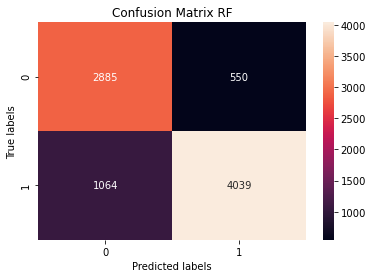

In [57]:
# Plot da confusion matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(df_3['churn_class_number'], predictRF_2), annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix RF'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

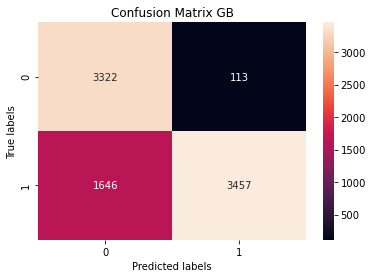

In [58]:
# Plot da confusion matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix(df_3['churn_class_number'], predictGB_2), annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix GB'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

In [59]:
df_3

,ano_mes_dt_cad_rep,cd_cliente,saldo_credev,saldo_adiantamento,score_empresas,negativacoes,pedidos,recencia,ds_tp_pessoa,volume_compra,...,frequency,recency,T,monetary_value,pred_num_trans_30,pred_trans_avg_value,CLV,prob_alive,predictRF_2,predictGB_2
0,2016-06-01,4194,0.00,0.00,1.0,88752.62,29.0,102.0,Juridica,ACIMA DE 90k,...,22.0,323.0,324.0,5848.337727,1.89,5855.60,122261.24,0.997032,1,0
1,2018-06-01,4512,129.99,129.99,622.0,0.00,15.0,57.0,Juridica,ACIMA DE 90k,...,22.0,323.0,324.0,4471.842273,1.89,4477.54,93488.24,0.997032,0,0
2,2018-06-01,6307,2.73,2.73,0.0,0.00,4.0,110.0,Fisica,ATÉ 10k,...,18.0,296.0,304.0,3631.973889,1.64,3637.77,65837.01,0.994641,1,1
3,2018-06-01,10755,219.80,219.80,1.0,13508.78,23.0,16.0,Juridica,ACIMA DE 90k,...,23.0,310.0,334.0,20726.692174,1.91,20749.80,435926.03,0.986928,0,0
4,2018-06-01,11778,0.00,0.00,390.0,0.00,40.0,62.0,Juridica,ACIMA DE 90k,...,5.0,66.0,323.0,6582.120000,0.03,6617.88,1986.45,0.060559,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,2021-11-01,66897,0.00,0.00,0.0,0.00,2.0,1.0,Fisica,ATÉ 10k,...,3.0,78.0,130.0,199.146667,0.56,205.40,1249.98,0.907799,1,0
9099,2021-11-01,66919,0.00,0.00,0.0,0.00,2.0,2.0,Fisica,ATÉ 10k,...,0.0,0.0,130.0,0.000000,0.05,-545.70,-269.02,1.000000,0,0
9100,2021-11-01,66953,0.00,0.00,0.0,0.00,2.0,1.0,Juridica,DE 10k A 30k,...,1.0,33.0,130.0,195.730000,0.11,214.71,259.00,0.469891,0,0
9101,2021-11-01,66976,0.00,401.94,0.0,0.00,2.0,1.0,Fisica,ATÉ 10k,...,1.0,26.0,130.0,127.490000,0.10,144.72,160.00,0.430664,0,0


In [60]:
# Plot da confusion matrix
# ax = plt.subplot()
# sns.heatmap(confusion_matrix(df_2['churn_class_number'], predictSVM_2), annot=True, fmt='g', ax=ax);

# labels, title and ticks
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix SVM'); 
# ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

In [61]:
# Plot da confusion matrix
# ax = plt.subplot()
# sns.heatmap(confusion_matrix(df_2['churn_class_number'], predictKN_2), annot=True, fmt='g', ax=ax);

# labels, title and ticks
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix KN'); 
# ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

In [62]:
# Plot da confusion matrix
# ax = plt.subplot()
# sns.heatmap(confusion_matrix(df_2['churn_class_number'], predictNB_2), annot=True, fmt='g', ax=ax);

# labels, title and ticks
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix NB'); 
# ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);